In [1]:
try:
    from imports import *
except ModuleNotFoundError:
    import sys; sys.path.append("../../")
    from imports import *

# Plasmon confinement in fractal quantum systems

In [4]:
os.makedirs("assets", exist_ok=True)
prefix = Path("data/data")

# A hack to shift the rasterized colorbar downward by a small offset...
# Matplotlibs's rendering is off, and without the shift, the colorbar looks ugly     
def _offset_colorbar(filename, index=0, offset=-0.012):
    with open(filename, "r") as out:
        s = out.read(); k = s[:s.find(f"-img{index}.png")].count("\n"); s = s.split("\n")
        x, y = re.search(r'transformshift\{(.+)in\}\{(.+)in\}', s[k - 1]).groups()
        s[k - 1] = s[k - 1].replace(f"transformshift{{{x}in}}{{{y}in}}", f"transformshift{{{x}in}}{{{float(y)+offset}in}}")
    with open(filename, "w") as out: out.write("\n".join(s))

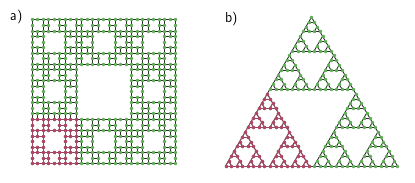

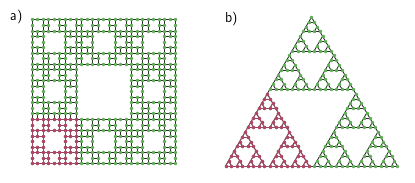

In [3]:
def _mk_edges(grid, f):
    n = grid.shape[0]
    x1, y1 = grid.nonzero(); x2, y2 = f(x1, y1)
    p = (x2 < n) & (y2 < n) & grid[x2 % n, y2 % n]
    return np.column_stack([x1[p], y1[p], x2[p], y2[p]]).reshape(-1, 2, 2)

def sierpinski_carpet(k=3):
    b0 = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]], dtype=bool)
    grid = reduce(lambda a, b: np.kron(b, a), [b0] * k)
    edges = np.vstack([
        _mk_edges(grid, lambda x, y: (x + 1, y)),
        _mk_edges(grid, lambda x, y: (x, y + 1))
    ])
    return *grid.nonzero(), edges

def sierpinski_gasket(k=3):
    b0 = np.array([[1, 0], [1, 1]], dtype=bool)
    grid = reduce(lambda a, b: np.kron(b, a), [b0] * k)
    edges = np.vstack([
        _mk_edges(grid, lambda x, y: (x + 1, y)),
        _mk_edges(grid, lambda x, y: (x, y + 1)),
        _mk_edges(grid, lambda x, y: (x + 1, y + 1))
    ])
    # transform axes
    t = np.array([[1, -0.5], [0, np.sqrt(3) / 2]])
    c = t @ np.vstack(grid.nonzero())
    edges = edges @ t.T
    return *c, edges

def _plot_graph(ax, xs, ys, edges, edgecolor="black"):
    ax.add_collection(LineCollection(edges, linewidth=0.6, color=edgecolor, zorder=-1))
    ax.scatter(xs, ys, s=2)

with plt.style.context(["science", "scatter", style]):
    xs1, ys1, edges1 = sierpinski_carpet(3)
    xs2, ys2, edges2 = sierpinski_gasket(5)
    cmap = plt.get_cmap(name=None)
    w = style["figure.figsize"][0]
    fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[xs1.max() - xs1.min(), xs2.max() - xs2.min()], figsize=(w, w / 2))
    _plot_graph(ax1, xs1, ys1, edges1, edgecolor="black")
    _plot_graph(ax2, xs2, ys2, edges2, edgecolor="black")
    ax1.axis('off'); ax1.set_aspect('equal'); ax1.text(-0.15 * xs1.max(), ys1.max(), "a)", fontsize=10)
    ax2.axis('off'); ax2.set_aspect('equal'); ax2.text(0, ys1.max(), "b)", fontsize=10)
    # Highlight smaller parts
    _plot_graph(ax1, *sierpinski_carpet(2), edgecolor="C1")
    _plot_graph(ax2, *sierpinski_gasket(4), edgecolor="C1")
    
    fig.savefig("./assets/Figure_1.pgf", backend="pgf")
fig

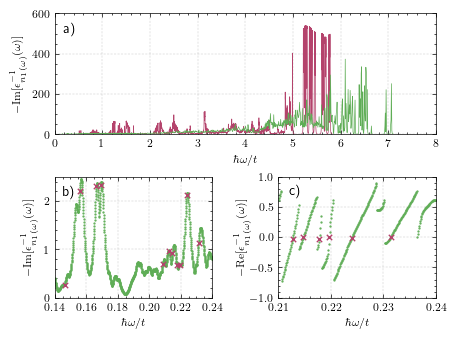

In [4]:
# true plasmon frequencies
freq = pd.read_csv(prefix / "sierpinski-carpet/1-3/Plasmons.1.3.1-high-res.dat", sep="\t", comment="#")["freq"][::2]
# combine high- and low-resolution data
t = pd.concat([
    pd.read_csv(prefix / "sierpinski-carpet/1-3/Spectrum.1.3.1-low-res.dat", sep="\t", comment="#"),
    pd.read_csv(prefix / "sierpinski-carpet/1-3/Spectrum.1.3.1-high-res.dat", sep="\t", comment="#")
]).drop_duplicates(["freq"], keep="last").sort_values("freq").reset_index(drop=True)
# mark plasmons
t = t.assign(plasmon=lambda df: df["freq"].isin(freq))
# rescale frequency to units of hopping
t = t.assign(freq=lambda df: df["freq"] / 2.8)
t2 = pd.read_csv(prefix / "sierpinski-gasket/1-6/Spectrum.1.6.1.dat", sep=r"\s+", comment="#") \
        .assign(freq=lambda df: df.freq / 2.8)

with plt.style.context(["science", "scatter", style]):
    fig = plt.figure(); fig.subplots_adjust(wspace=0.42, hspace=0.35)
    ax1, ax2, ax3 = fig.add_subplot(2, 2, (1, 2)), fig.add_subplot(2, 2, 3), fig.add_subplot(2, 2, 4)
    ax1.plot(t2["freq"], t2["loss"], "C1", linestyle="-", linewidth=0.5, marker="")
    ax1.plot(t["freq"], t["loss"], "C0", linestyle="-", linewidth=0.5, marker="")
    ax1.set_xlabel(r"$\hbar \omega / t$"); ax1.set_ylabel(r"$-\mathrm{Im}[\epsilon^{-1}_{n_1(\omega)}(\omega)]$")
    ax1.grid(); ax1.set_xlim((0, 8)); ax1.set_ylim((0, 600));
    ax1.text(0.17, 500, "a)", fontsize=10)

    tz = t.query("0.14 < freq < 0.24")
    ax2.scatter(tz["freq"], tz["loss"], s=0.4)
    ax2.scatter(tz[tz["plasmon"]]["freq"], tz[tz["plasmon"]]["loss"], s=15, marker="x", linewidth=1)
    ax2.set_xlabel(r"$\hbar \omega / t$"); ax2.set_ylabel(r"$-\mathrm{Im}[\epsilon^{-1}_{n_1(\omega)}(\omega)]$")
    ax2.grid(); ax2.set_xlim((0.14, 0.24)); ax2.set_ylim((0, 2.5))
    ax2.xaxis.set_ticks([0.14, 0.16, 0.18, 0.2, 0.22, 0.24])
    ax2.text(0.145, 2.1, "b)", fontsize=10)

    tz = t.query("0.21 < freq < 0.24")
    ax3.scatter(tz["freq"], tz["real"], s=0.4)
    ax3.scatter(tz[tz["plasmon"]]["freq"], tz[tz["plasmon"]]["real"], s=15, marker="x", linewidth=1)
    ax3.set_xlabel(r"$\hbar \omega / t$"); ax3.set_ylabel(r"$-\mathrm{Re}[\epsilon^{-1}_{n_1(\omega)}(\omega)]$", labelpad=-1)
    ax3.grid(); ax3.set_xlim((0.21, 0.24)); ax3.set_ylim((-1, 1))
    ax3.text(0.212, 0.7, "c)", fontsize=10)

    fig.savefig("./assets/Figure_2.pgf", backend="pgf")
fig

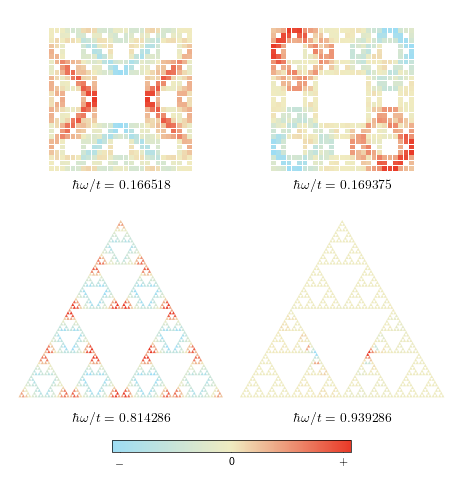

In [6]:
t1 = pd.read_csv(prefix / "sierpinski-carpet/1-3/Epsilon.1.3.0.466250.1.eigenstate.dat", sep="\t", comment="#")
t2 = pd.read_csv(prefix / "sierpinski-carpet/1-3/Epsilon.1.3.0.474250.1.eigenstate.dat", sep="\t", comment="#")
t3 = pd.read_csv(prefix / "sierpinski-gasket/1-6/Epsilon.1.6.2.280000.1.eigenstate.dat", sep=r"\s+", comment="#")
t4 = pd.read_csv(prefix / "sierpinski-gasket/1-6/Epsilon.1.6.2.630000.1.eigenstate.dat", sep=r"\s+", comment="#")
with plt.style.context(["science", "scatter", style]):
    w = style["figure.figsize"][0]
    fig = plt.figure(figsize=(0.9 * w, 0.9 * w))
    subfigs = fig.subfigures(3, 1, height_ratios=[3, 4, 0.4])
    ((ax1, ax2), (ax3, ax4)) = subfigs[0].subplots(1, 2), subfigs[1].subplots(1, 2)
    for ax in [ax1, ax2, ax3, ax4]: ax.margins(0.05, 0.15); ax.axis('off'); ax.set_aspect('equal')
    fig.subplots_adjust(left=0, bottom=0, right=1.0, top=1.0, wspace=0, hspace=0)
    # subfigs[2].subplots_adjust(left=0.3, right=0.7, top=0.4)
    ax1.scatter(t1["x"], t1["y"], c=t1["real"], s=12, marker="s", edgecolors='none')
    cm = ax2.scatter(t2["x"], t2["y"], c=t2["real"], s=12, marker="s", edgecolors='none')
    ax3.scatter(t3["x"], t3["y"], c=t3["real"], s=5, marker="^", edgecolors='none')
    ax4.scatter(t4["x"], t4["y"], c=t4["real"], s=5, marker="^", edgecolors='none')
    for ax, freq in zip([ax1, ax2, ax3, ax4], ["0.166518", "0.169375", "0.814286", "0.939286"]):
        ax.set_title(r"$\hbar\omega / t = " + freq + "$", y=0, pad=0)

    ax5 = subfigs[2].subplots(); ax5.axis("off")
    cb = fig.colorbar(cm, ticks=[-0.1, 0, 0.1], fraction=0.5, shrink=0.9, orientation="horizontal", ax=ax5,
                      format=matplotlib.ticker.FixedFormatter(['$-$', '0', '$+$']))
    cb.minorticks_off(); cb.solids.set_rasterized(True)
    # This is a hack to shift the rasterized part downwards by a small offset...
    # Matplotlibs's rendering is off, and without the shift, the colorbar looks ugly 
    f = "./assets/Figure_3.pgf"
    fig.savefig(f, backend="pgf")
    _offset_colorbar(f)
fig

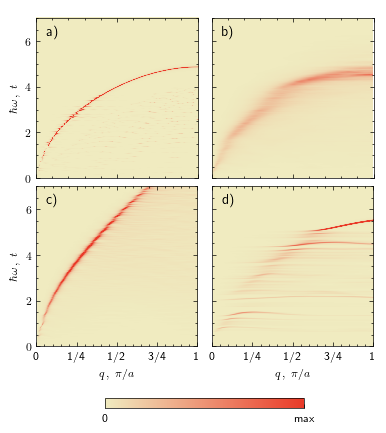

In [5]:
def _loss(ax, f, scale=1):
    loss = np.loadtxt(f); q, freq = loss[0, 1:] / (np.pi / 0.24612E-9), loss[1:, 0] / 2.8
    loss = scale * loss[1:, 1:][np.argsort(freq)]
    freq = np.sort(freq)
    if np.diff(freq).std() > 1e-6:
        im = matplotlib.image.NonUniformImage(ax, interpolation="nearest", extent=(q.min(), q.max(), freq.min(), freq.max()),
                                              norm=matplotlib.colors.Normalize(vmin=0, vmax=6),
                                              cmap=my_cmap4)
        im.set_data(q, freq, loss); ax.add_image(im); ax.set_aspect(1 / 7.06)
    else:
        cm = ax.imshow(loss, aspect=(q.max() - q.min()) / (freq.max() - freq.min()),
                       vmin=0, vmax=6, extent=(q.min(), q.max(), freq.min(), freq.max()),
                       cmap=my_cmap4, origin="lower") # , interpolation="none")
        return cm

matplotlib.pyplot.close("all")
with plt.style.context(["science", "scatter", style]):
    w = style["figure.figsize"][0]
    fig = plt.figure(figsize=(0.9 * w, 0.9 * w))
    subfigs = fig.subfigures(2, 1, height_ratios=[0.95, 0.05])    
    (ax1, ax2), (ax3, ax4) = subfigs[0].subplots(2, 2)
    subfigs[0].subplots_adjust(hspace=0.05, wspace=0.05, bottom=0.1)
    _loss(ax1, prefix / "square-lattice/1-3/Dispersion-X.dat")
    _loss(ax2, prefix / "sierpinski-carpet/1-4/Dispersion-X.dat", scale=9)
    _loss(ax3, prefix / "triangular-lattice/1-5/Dispersion-X.dat")
    cm = _loss(ax4, prefix / "sierpinski-gasket/1-6/Dispersion-X.dat")
    for i, ax in enumerate([ax1, ax2, ax3, ax4]):
        ax.set_xlim(0, 1); ax.set_ylim(0, 7); ax.text(0.06, 6.25, chr(ord("a") + i) + ")", fontsize=10)
    ax1.tick_params(axis='both', which="both", labelbottom=False)
    ax2.tick_params(axis='both', which="both", labelleft=False, labelbottom=False)
    ax4.tick_params(axis='both', which="both", labelleft=False)
    for ax in [ax3, ax4]: ax.set_xticks([0, 0.25,  0.5, 0.75, 1], labels=["0", "1/4", "1/2", "3/4", "1"])
    for ax in [ax1, ax3]: ax.set_ylabel(r"$\hbar\omega\,,\;t$")
    for ax in [ax3, ax4]: ax.set_xlabel(r"$q\,,\;\pi/a$")

    ax5 = subfigs[1].subplots(); subfigs[1].subplots_adjust(top=1); ax5.axis("off")
    cb = fig.colorbar(cm, fraction=0.5, shrink=0.9, orientation="horizontal", ax=ax5,
                      ticks=[0, 6], format=matplotlib.ticker.FixedFormatter(['0', 'max']))
    cb.minorticks_off(); cb.solids.set_rasterized(True)
    
    f = "./assets/Figure_4.pgf"
    fig.savefig(f, backend="pgf")
    _offset_colorbar(f, index=4)
fig